# Deep learning based quantum vortex detection in atomic Bose-Einstein condensates

### Detection & Classification

Created by Friederike Metz

This jupyter notebook accompanies the paper: [Deep learning based quantum vortex detection in atomic Bose-Einstein condensates](https://arxiv.org/abs/2012.13097)

In this notebook the machine learning model also learns to classify the circulation direction of a detected vortex, i.e. whether a given vortex rotates clock or counter-clockwise.

#### Content
1. Read and prepare training & test data
3. Define architecture
    * Load pretrained model
4. Define loss function
5. Training
6. Model evaluation
    * Visualize the results

Import all necessary libraries

In [1]:
using Random, Distributions
using DelimitedFiles
using PyPlot
#using CuArrays # if gpu available
using Flux, NNlib
using Flux.Optimise: update!
using Base.Iterators: partition
using BSON: @save, @load

In [2]:
# costum functions needed for this notebook
include("utils.jl");

In [3]:
classes = true;

In [4]:
# fix random seed for reproducability
Random.seed!(1234);

## 1. Read and prepare training & test data

Read your training and/or test data here. As an example we will load two out-of-equilibria configurations and their ground-truth labels.

In [5]:
# image related parameters
n_images = 2
image_size = 256 # if this is changed the architecture of the NN has to be altered accordingly
max_objects = 50 # maximum number of vortices in any image (set it to a large value to be safe)

# grid related parameters
grid_size = 64 # if this is changed the architecture of the NN has to be altered accordingly
@assert image_size % grid_size == 0 # image_size should be divisible by grid_size
grid_cell = image_size ÷ grid_size;

In [6]:
# read images: the two channels are density and phase respectively
images = reshape(readdlm("example_data/images2.dat"), image_size, image_size, 2, n_images)
# read corresponding ground truth postition obtained from "brute-force" detection
true_positions = reshape(readdlm("example_data/labels2.dat"), max_objects, 3, n_images);

To help the CNN with training, image pixels should be normalized to lie between [0,1]

In [7]:
for i = 1:n_images
    scaling_factor = maximum(images[:,:,1,i])
    if scaling_factor != 1.0
        images[:,:,1,i] = images[:,:,1,i] ./ scaling_factor
        images[:,:,2,i] = (images[:,:,2,i] .+ pi) ./ (2*pi)
    end
end;

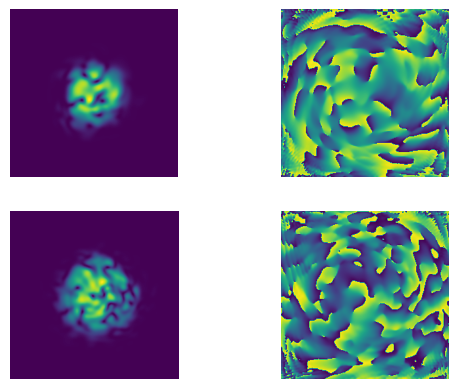

In [8]:
subplot(221)
PyPlot.imshow(images[:,:,1,1])
axis("off")
subplot(222)
PyPlot.imshow(images[:,:,2,1])
axis("off")
subplot(223)
PyPlot.imshow(images[:,:,1,2])
axis("off")
subplot(224)
PyPlot.imshow(images[:,:,2,2])
axis("off");

The following two cells convert the list of positions of vortices to a $64\times 63\times 4$ label tensor used for training and vice versa

In [9]:
# Convert list of x,y positions of each vortex to a 64x64x4 label tensor
true_labels = convert_positions_to_labels(true_positions; classes);

In [10]:
# Convert 64x64x4 label tensor to list of x,y positions of each vortex
true_pos, confidence = convert_labels_to_positions(true_labels; classes);

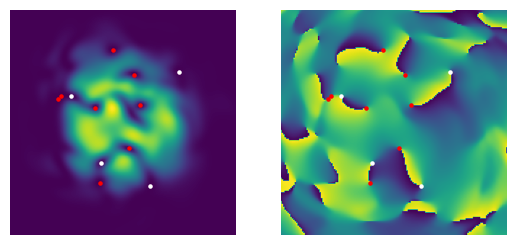

In [11]:
n = 1 # 2
subplot(121)
PyPlot.imshow(images[:,:,1,n])
for i=1:size(true_pos[n], 1)
    if true_pos[n][i,3] == 1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=5, marker="o", c="red")
    elseif true_pos[n][i,3] == -1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=5, marker="o", c="white")
    end
end
ax = gca()
x = 50
ax.set_ylim([x,256-x])
ax.set_xlim([x,256-x])
axis("off");
subplot(122)
PyPlot.imshow(images[:,:,2,n])
for i=1:size(true_pos[n], 1)
    if true_pos[n][i,3] == 1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=5, marker="o", c="red")
    elseif true_pos[n][i,3] == -1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=5, marker="o", c="white")
    end
end
ax = gca()
ax.set_ylim([x,256-x])
ax.set_xlim([x,256-x])
axis("off");

In [12]:
# Split data into training and test set
train_test_ratio = 0.5 #0.8
train_images, train_labels, test_images, test_labels = split_data(images, true_labels, train_test_ratio=train_test_ratio);

In [13]:
# Split training data into minitbatches (faster on cpu)
batch_size = 100

train_images = train_images|> cpu
train_labels = train_labels|> cpu

mb_idxs = partition(1:size(train_images, 4), batch_size)
train_set = [make_minibatch(train_images, train_labels, i) for i in mb_idxs];

In [14]:
# move data to gpu if available
train_images = train_images|> gpu
test_images = test_images|> gpu

train_labels = train_labels|> gpu
test_labels = test_labels|> gpu

train_set = train_set|> gpu;

## 2. Define architecture
The CNN architecture used for the paper. Input/output channels have to match the desired in and output of the CNN.

In [15]:
function initialize_model(input_channels; output_channels=4, channels=10, activation=relu)
    """ Returns randomly initialized CNN model """
    model = Chain(
        Conv((3, 3), input_channels=>channels, pad=(1,1), stride = 1, activation),
        Conv((3, 3), channels=>channels, pad=(1,1), stride = 1, activation),
        MaxPool((2,2), stride = 2),
        Conv((3, 3), channels=>2*channels, pad=(1,1), stride = 1, activation),
        Conv((3, 3), 2*channels=>2*channels, pad=(2,2), stride = 1, activation),
        MaxPool((2,2), stride = 2),
        Conv((3, 3), 2*channels=>3*channels, pad=(1,1), stride = 1, activation),
        MaxPool((2,2), stride = 1),
        Conv((3, 3), 3*channels=>4*channels, pad=(1,1), stride = 1, activation),
        Conv((1, 1), 4*channels=>output_channels, pad=(0,0), stride = 1, sigmoid),
    )|> gpu;
    return model
end;

In [16]:
# reset model
input_channels = size(train_images[:,:,:,1], 3)
model = initialize_model(input_channels);
# Check if the output dimensions are correct, i.e. match the label tensor
size(model(test_images[:,:,:,1:1]))

(64, 64, 4, 1)

### Load pretrained model

You can also use one of the models from the paper that has already been trained.

In [17]:
# two input channels (density and phase):
model_name = "density_and_phase_classes.bson"

"density_and_phase_classes.bson"

In [18]:
# load weights
savepath="models/"
@load joinpath(savepath, model_name) weights
Flux.loadparams!(model, weights)

In [ ]:
# saving a model
#@save joinpath(savepath, "model_name.bson") weights=cpu.(Flux.params(model))

## 3. Define loss function

In [19]:
# Loss function for detection and classification task
function loss(model, x, y) 
    """ Returns loss: Sum of cross-entropy loss for the class probabilities and L2 loss for the positions """
    y_hat = model(x)
    loss = sum((- 10.0f0 .* y[:,:,1,:] .* log.(y_hat[:,:,1,:] .+ 0.000001f0) .- (1 .- y[:,:,1,:]) .* log.(1 .- y_hat[:,:,1,:] .+ 0.000001f0))
            .+(- 10.0f0 .* y[:,:,2,:] .* log.(y_hat[:,:,2,:] .+ 0.000001f0) .- (1 .- y[:,:,2,:]) .* log.(1 .- y_hat[:,:,2,:] .+ 0.000001f0))
            .+ 10.0f0 .* (y[:,:,1,:] .+ y[:,:,2,:]) .* ((y_hat[:,:,4,:] .- y[:,:,4,:]).^2 .+ (y_hat[:,:,3,:] .- y[:,:,3,:]).^2)
            ) # L2 loss
    return loss
end;

## 4. Training

In [ ]:
optimizer = ADAM(0.001)
epochs = 10

@time model, losses = train(loss,
                            optimizer,
                            epochs,
                            model,
                            train_set,
                            test_images,
                            test_labels);

In [ ]:
ylabel("Loss")
xlabel("Epoch")
plot(losses);

## 5. Model evaluation

To evaluate the performance of the vortex detector we compute average precision (AP) and the maximum F1 score. The corresponding optimal confindence threshold is then used to calculate the optimal precision and recall.

In [ ]:
confidence_threshold = 0.75
distance_threshold = 2.3 # ~sqrt(5)

# Evaluation metrics
precisions, recalls, opt_conf_thres, f1_max, opt_prec, opt_recall = precision_recall_curve(model, test_images, test_labels; distance_threshold=distance_threshold, classes)
ap = [mean(precisions[1]), mean(precisions[2])]

println("Optimal confidence threshold: ", opt_conf_thres)
println("Optimal precision: ", opt_prec)
println("Optimal recall: ", opt_recall)
println("AP: ", ap)
println("mAP: ", mean(ap))
println("Max F1 score: ", f1_max)
println("Mean max F1 score: ", mean(f1_max))

In [ ]:
plot(recalls[1], precisions[1], label="vortex")
plot(recalls[2], precisions[2], label="anti-vortex")
legend()
xlabel("Recall")
ylabel("Precision");

### Visualize the results
Compare the predicted and ground-truth positions

In [20]:
opt_conf_thres = [0.85,0.85]

predicted_labels = nms(model(images[:,:,:,1:2]|> gpu); classes) # nms: non-max suppression
predicted_pos, conf = convert_labels_to_positions(predicted_labels, threshold=opt_conf_thres; classes)
true_pos, conf = convert_labels_to_positions(true_labels; classes);

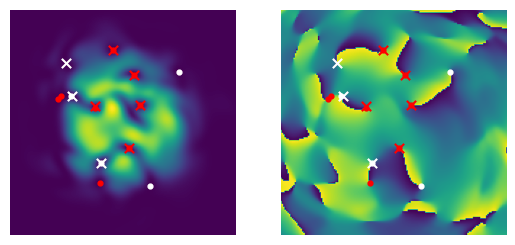

In [21]:
n = 1 # change to see the other images

subplot(121)
PyPlot.imshow(images[:,:,1,n])
for i=1:size(true_pos[n], 1)
    if true_pos[n][i,3] == 1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="red")
    elseif true_pos[n][i,3] == -1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="white")
    end
end
for i=1:size(predicted_pos[n], 1)
    if predicted_pos[n][i,3] == 1.0
        PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="red")
    elseif predicted_pos[n][i,3] == -1.0
        PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="white")
    end
end
ax = gca()
x = 50
ax.set_ylim([x,256-x])
ax.set_xlim([x,256-x])
axis("off")

subplot(122)
PyPlot.imshow(images[:,:,2,n])
for i=1:size(true_pos[n], 1)
    if true_pos[n][i,3] == 1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="red")
    elseif true_pos[n][i,3] == -1.0
        PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="white")
    end
end
for i=1:size(predicted_pos[n], 1)
    if predicted_pos[n][i,3] == 1.0
        PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="red")
    elseif predicted_pos[n][i,3] == -1.0
        PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="white")
    end
end
ax = gca()
ax.set_ylim([x,256-x])
ax.set_xlim([x,256-x])
axis("off");

In the figures above circles indicate the "ground-truth" and crosses the model prediction. Different colors correspond to different classes, i.e. circulation directions.